In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np

In [2]:
batch_size = 100
img_sz = 28
img_len = img_sz*img_sz
n_itr = 10000
n_class = 10
lstm_size = 256
T = 10
A = img_sz
B = img_sz
eps = 1e-7
N = 5
lr = 1e-3

In [3]:
# calculate F_x and F_y
def get_Fx_Fy(h):
    params = tf.matmul(h, params_W) + params_b
    g_x_, g_y_, log_var_Fxy, log_delta_, log_gamma = tf.split(1, 5, params)
    var_Fxy = tf.exp(log_var_Fxy)
    gamma = tf.exp(log_gamma)
    
    g_x = ((A + 1) * 0.5) * (g_x_ + 1)
    g_y = ((B + 1) * 0.5) * (g_y_ + 1)
    delta = ((max(A, B) - 1) / (N - 1)) * tf.exp(log_delta_)

    filter_i = tf.reshape(tf.cast(tf.range(N), tf.float32), [1, -1])
    mu_x = g_x + (filter_i - N / 2 - 0.5) * delta
    mu_y = g_y + (filter_i - N / 2 - 0.5) * delta

    a = tf.reshape(tf.cast(tf.range(A), tf.float32), [1, 1, -1])
    b = tf.reshape(tf.cast(tf.range(B), tf.float32), [1, 1, -1])
    mu_x = tf.reshape(mu_x, [-1, N, 1])
    mu_y = tf.reshape(mu_y, [-1, N, 1])
    var_Fxy = tf.reshape(var_Fxy, [-1, 1, 1])    
    
    F_x = tf.exp(-tf.square((a - mu_x) / (2 * var_Fxy)))
    F_y = tf.exp(-tf.square((b - mu_y) / (2 * var_Fxy))) 
    
    F_x = F_x / tf.maximum(tf.reduce_sum(F_x, 2, keep_dims=True), eps)
    F_y = F_y / tf.maximum(tf.reduce_sum(F_y, 2, keep_dims=True), eps)
    return (F_x, F_y, gamma)

In [4]:
def read(r, F_x, F_y, gamma):
    # (F_x.T r F_y) * gamma
    r = tf.reshape(r, [-1, B, A])
    F_x_transpose = tf.transpose(F_x, perm=[0,2,1])
    r = tf.batch_matmul(F_y, tf.batch_matmul(r, F_x_transpose))
    r = tf.reshape(r, [-1, N*N])
    r = r * tf.reshape(gamma,[-1,1])
    return r

In [5]:
def write(w, F_x, F_y, gamma):
    # (F_y.T w_ F_x) / gamma
    w = tf.reshape(w, [batch_size, N, N])
    F_y_transpose = tf.transpose(F_y, perm=[0,2,1])
    w = tf.batch_matmul(F_y_transpose, tf.batch_matmul(w, F_x))
    w = tf.reshape(w, [batch_size, B*A])
    w = w * tf.reshape(1.0/gamma,[-1,1])
    return w

In [6]:
x = tf.placeholder(tf.float32, [batch_size, img_len])
y_ = tf.placeholder(tf.float32, [batch_size, n_class])

rnn_enc = tf.nn.rnn_cell.LSTMCell(lstm_size)
rnn_dec = tf.nn.rnn_cell.LSTMCell(lstm_size)

write_W = tf.Variable(tf.zeros([lstm_size, N*N]))
write_b = tf.Variable(tf.zeros([N*N]))

mu_W = tf.Variable(tf.zeros([lstm_size, n_class]))
mu_b = tf.Variable(tf.zeros([n_class]))

log_sigma_W = tf.Variable(tf.zeros([lstm_size, n_class]))
log_sigma_b = tf.Variable(tf.zeros([n_class]))

params_W = tf.Variable(tf.zeros([lstm_size, 5]))
params_b = tf.Variable(tf.zeros([5]))

In [7]:
# stochastic data generation
c = [0]*T
state_dec = rnn_dec.zero_state(batch_size, tf.float32) 

for t in range(T):
    z = tf.random_normal([batch_size, n_class], mean=0, stddev=1)

    # decoder
    with tf.variable_scope("decoder", reuse=(t != 0)):
        h_dec, state_dec = rnn_dec(z, state_dec) 
    
    # no atten
    w = tf.matmul(h_dec, write_W) + write_b
        
    #write       
    F_x, F_y, gamma = get_Fx_Fy(h_dec)
    w = write(w, F_x, F_y, gamma)
    
    c_prev = tf.zeros([batch_size, img_len]) if t==0 else c[t-1]
    c[t] = c_prev + w

In [16]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
ckpt_file= "saved_models/draw_model.ckpt"

saver.restore(sess, ckpt_file)
print("Model restored")

Model restored


In [17]:
output_images = sess.run(c) 
output_images = np.array(output_images) 

out_file="draw_data_stochastic.npy"
np.save(out_file,[output_images])
print("Outputs saved in file: %s" % out_file)

sess.close()

Outputs saved in file: draw_data_stochastic.npy


In [14]:
# taken from https://github.com/ericjang/draw/blob/master/plot_data.py

import matplotlib
import sys
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

def xrecons_grid(X,B,A):
    padsize=1
    padval=.5
    ph=B+2*padsize
    pw=A+2*padsize
    batch_size=X.shape[0]
    N=int(np.sqrt(batch_size))
    X=X.reshape((N,N,B,A))
    img=np.ones((N*ph,N*pw))*padval
    for i in range(N):
        for j in range(N):
            startr=i*ph+padsize
            endr=startr+B
            startc=j*pw+padsize
            endc=startc+A
            img[startr:endr,startc:endc]=X[i,j,:,:]
    return img

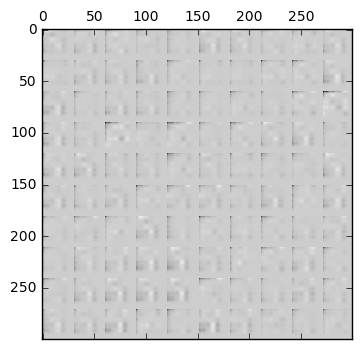

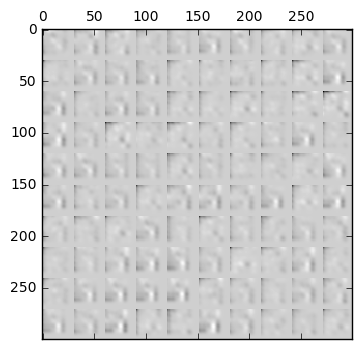

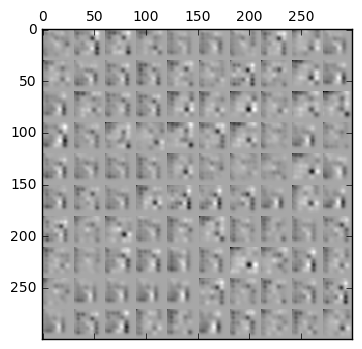

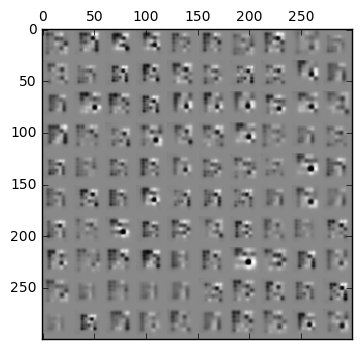

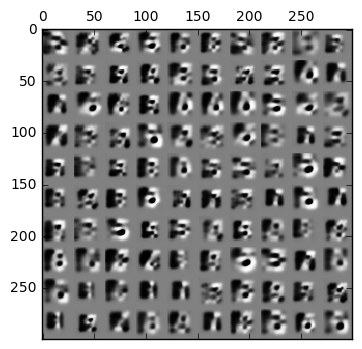

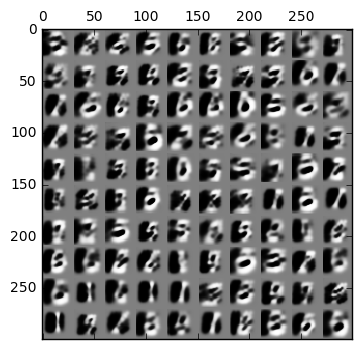

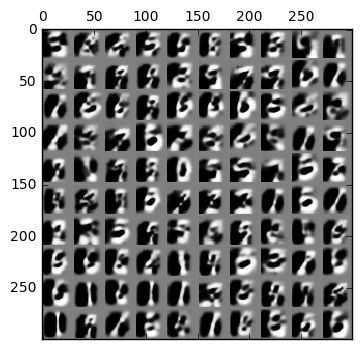

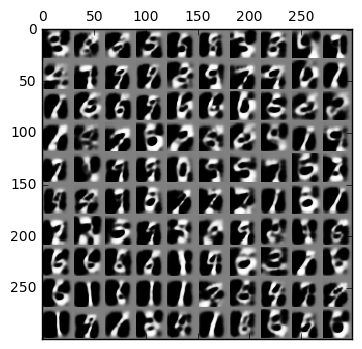

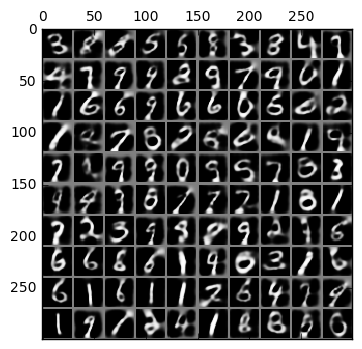

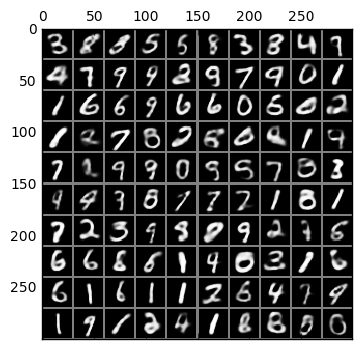

In [15]:
out_file="draw_data_stochastic.npy"
[C] =np.load(out_file)
T,batch_size,img_size=C.shape
X=1.0/(1.0+np.exp(-C)) 
B=A=int(np.sqrt(img_size))

for t in range(T):
    img=xrecons_grid(X[t,:,:],B,A)
    plt.matshow(img,cmap=plt.cm.gray)

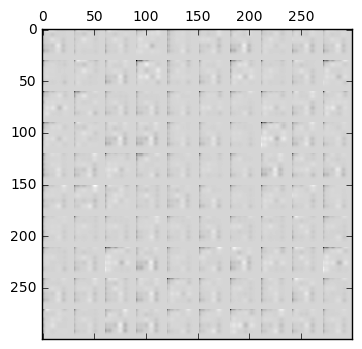

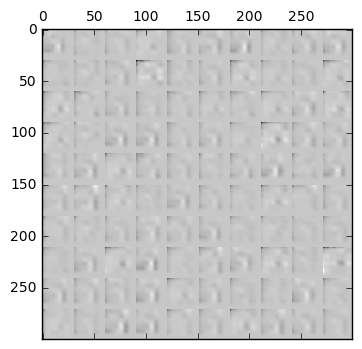

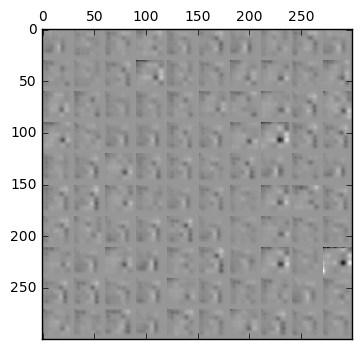

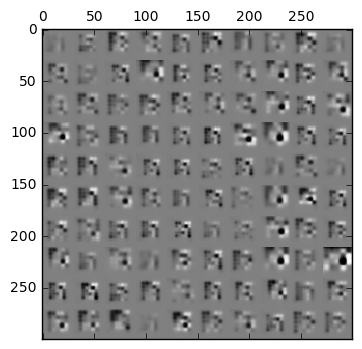

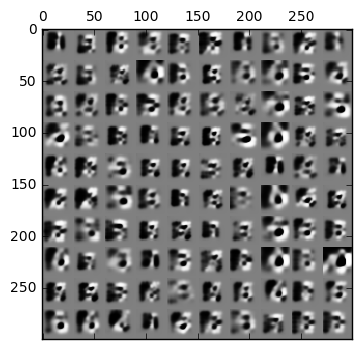

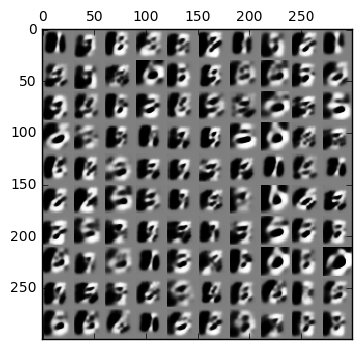

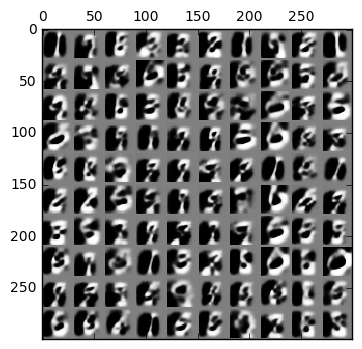

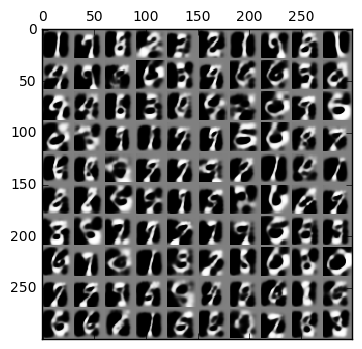

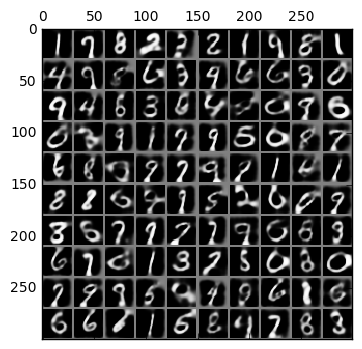

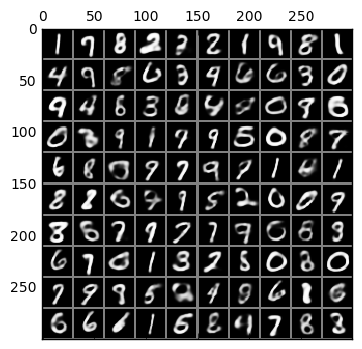

In [18]:
out_file="draw_data_stochastic.npy"
[C] =np.load(out_file)
T,batch_size,img_size=C.shape
X=1.0/(1.0+np.exp(-C)) 
B=A=int(np.sqrt(img_size))

for t in range(T):
    img=xrecons_grid(X[t,:,:],B,A)
    plt.matshow(img,cmap=plt.cm.gray)